In [1]:
import pandas as pd
import os
import re

In [2]:
data = pd.read_excel("C:\\Users\\mallisetty.praditha\\Downloads\\Market_Center 1.xlsx")

In [3]:
data.columns

Index(['market_center_name', 'year', 'month', 'api_count'], dtype='object')

In [4]:
data.groupby('market_center_name')['year'].agg(['min', 'max'])

,min,max
market_center_name,,
Bakken,1921,2025
Beaumont/Mont Belvieu,1906,2025
Corpus Christi,1906,2025
Cushing,1900,2025
Eagle Ford,1906,2025
Houston,1906,2025
Louisiana Gulf Coast,1906,2025
Permian,1900,2025
Rest,1875,2025


In [5]:

def last_n_years_per_play_type(df, n=8):
    return df.groupby('market_center_name', group_keys=False).apply(
        lambda g: g[g['year'] >= g['year'].max() - (n - 1)]
    )

# Usage:
data = last_n_years_per_play_type(data, n=10)

# Check result
print(data.groupby('market_center_name')['year'].agg(['min', 'max']))

                        min   max
market_center_name               
Bakken                 2016  2025
Beaumont/Mont Belvieu  2016  2025
Corpus Christi         2016  2025
Cushing                2016  2025
Eagle Ford             2016  2025
Houston                2016  2025
Louisiana Gulf Coast   2016  2025
Permian                2016  2025
Rest                   2016  2025
Rockies                2016  2025


C:\Users\mallisetty.praditha\AppData\Local\Temp\ipykernel_20072\4026243205.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('market_center_name', group_keys=False).apply(


In [6]:
data['market_center_name'].unique()

array(['Bakken', 'Beaumont/Mont Belvieu', 'Corpus Christi', 'Cushing',
       'Eagle Ford', 'Houston', 'Louisiana Gulf Coast', 'Permian', 'Rest',
       'Rockies'], dtype=object)

In [7]:
# Create individual dataframes
bakken_df = data[data['market_center_name'] == 'Bakken']
beaumont_df = data[data['market_center_name'] == 'Beaumont/Mont Belvieu']
corpus_christi_df = data[data['market_center_name'] == 'Corpus Christi']
cushing_df = data[data['market_center_name'] == 'Cushing']
eagle_ford_df = data[data['market_center_name'] == 'Eagle Ford']
houston_df = data[data['market_center_name'] == 'Houston']
louisiana_df = data[data['market_center_name'] == 'Louisiana Gulf Coast']
permian_df = data[data['market_center_name'] == 'Permian']
rest_df = data[data['market_center_name'] == 'Rest']
rockies_df = data[data['market_center_name'] == 'Rockies']

print(f"Bakken: {len(bakken_df)} rows")
print(f"Beaumont/Mont Belvieu: {len(beaumont_df)} rows")
print(f"Corpus Christi: {len(corpus_christi_df)} rows")
print(f"Cushing: {len(cushing_df)} rows")
print(f"Eagle Ford: {len(eagle_ford_df)} rows")
print(f"Houston: {len(houston_df)} rows")
print(f"Louisiana Gulf Coast: {len(louisiana_df)} rows")
print(f"Permian: {len(permian_df)} rows")
print(f"Rest: {len(rest_df)} rows")
print(f"Rockies: {len(rockies_df)} rows")

Bakken: 120 rows
Beaumont/Mont Belvieu: 120 rows
Corpus Christi: 120 rows
Cushing: 120 rows
Eagle Ford: 120 rows
Houston: 120 rows
Louisiana Gulf Coast: 120 rows
Permian: 120 rows
Rest: 120 rows
Rockies: 120 rows


In [8]:
houston_df['date'] = pd.to_datetime(houston_df[['year', 'month']].assign(day=1))
houston_df = houston_df.set_index('date').sort_index()

C:\Users\mallisetty.praditha\AppData\Local\Temp\ipykernel_20072\1239867935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houston_df['date'] = pd.to_datetime(houston_df[['year', 'month']].assign(day=1))


In [9]:
houston_df.head()

,market_center_name,year,month,api_count
date,,,,
2016-01-01,Houston,2016,1,90
2016-02-01,Houston,2016,2,68
2016-03-01,Houston,2016,3,64
2016-04-01,Houston,2016,4,81
2016-05-01,Houston,2016,5,68


### Model Fit

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import warnings
warnings.filterwarnings('ignore')


def forecast_model_comparison(df, x_col, y_col, test_size=0.2, scale_features=True, random_state=42):
    """
    Compare multiple regression models for time series forecasting
    
    Parameters:
    - df: DataFrame with time series data (must have datetime index)
    - x_col: Column name(s) for features (can be string or list of strings)
    - y_col: Column name for target variable
    - test_size: Proportion of data for testing (default=0.2)
    - scale_features: Whether to scale features (default=True)
    - random_state: Random state for reproducibility
    
    Returns:
    - results_df: DataFrame with model performance metrics
    - predictions_df: DataFrame with actual vs predicted values for all models
    - best_model_name: Name of the best performing model
    - trained_models: Dictionary of all trained models
    """
    
    # Handle single column or multiple columns for X
    if isinstance(x_col, str):
        x_col = [x_col]
    
    # Prepare data
    df_clean = df[[*x_col, y_col]].dropna().copy()
    
    if len(df_clean) == 0:
        print("Error: No valid data after removing NaN values")
        return None, None, None, None
    
    # Split data (no shuffling for time series)
    split_idx = int(len(df_clean) * (1 - test_size))
    
    X = df_clean[x_col].values
    y = df_clean[y_col].values
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print(f"Total samples: {len(df_clean)}")
    print(f"Training samples: {len(X_train)} ({(1-test_size)*100:.1f}%)")
    print(f"Testing samples: {len(X_test)} ({test_size*100:.1f}%)")
    print(f"Features: {x_col}")
    print(f"Target: {y_col}\n")
    
    # Scale features if requested
    # if scale_features:
    #     scaler = StandardScaler()
    #     X_train_scaled = scaler.fit_transform(X_train)
    #     X_test_scaled = scaler.transform(X_test)
    # else:
    X_train_scaled = X_train
    X_test_scaled = X_test
    
    # X_train.to_excel('X_train.xlsx')
    # X_test.to_excel('X_test.xlsx')
    
    # Define models to compare
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=random_state),
        'Lasso Regression': Lasso(alpha=1.0, random_state=random_state),
        'ElasticNet': ElasticNet(alpha=1.0, random_state=random_state),
    }
    
    # Train and evaluate each model
    results = []
    predictions = {'actual': y_test}
    print(predictions)
    trained_models = {}
    
    print("="*80)
    print("TRAINING AND EVALUATING MODELS...")
    print("="*80)
    
    for model_name, model in models.items():
        try:
            print(f"Training {model_name}...", end=" ")
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Predict on train and test sets
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            
            # Calculate MAPE (Mean Absolute Percentage Error)
            test_mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100
            
            results.append({
                'Model': model_name,
                'Train R²': train_r2,
                'Test R²': test_r2,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Train MAE': train_mae,
                'Test MAE': test_mae,
                'Test MAPE (%)': test_mape,
                'Overfit Score': train_r2 - test_r2  # Positive = overfitting
            })
            
            predictions[model_name] = y_test_pred
            trained_models[model_name] = model
            
            print(f"✓ (Test R²: {test_r2:.4f}, RMSE: {test_rmse:.4f})")
            
        except Exception as e:
            print(f"✗ Failed: {str(e)}")
            continue
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)
    
    # Create predictions DataFrame
    predictions_df = pd.DataFrame(predictions, index=df_clean.index[split_idx:])
    print(predictions_df.head(30))
    # Get best model
    best_model_name = results_df.iloc[0]['Model']
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(results_df.to_string(index=False))
    print("\n" + "="*80)
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"   Test R²: {results_df.iloc[0]['Test R²']:.4f}")
    print(f"   Test RMSE: {results_df.iloc[0]['Test RMSE']:.4f}")
    print(f"   Test MAE: {results_df.iloc[0]['Test MAE']:.4f}")
    print(f"   Test MAPE: {results_df.iloc[0]['Test MAPE (%)']:.2f}%")
    print("="*80)
    
    return results_df, predictions_df, best_model_name, trained_models


def plot_model_comparison(results_df, predictions_df, top_n=5):
    """
    Visualize model comparison results
    
    Parameters:
    - results_df: DataFrame with model performance metrics
    - predictions_df: DataFrame with actual vs predicted values
    - top_n: Number of top models to plot (default=5)
    """
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. R² Score Comparison
    ax1 = plt.subplot(3, 3, 1)
    results_top = results_df.head(10)
    x_pos = np.arange(len(results_top))
    ax1.barh(x_pos, results_top['Test R²'], alpha=0.8, color='steelblue')
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(results_top['Model'], fontsize=9)
    ax1.set_xlabel('Test R² Score')
    ax1.set_title('R² Score Comparison', fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. RMSE Comparison
    ax2 = plt.subplot(3, 3, 2)
    ax2.barh(x_pos, results_top['Test RMSE'], alpha=0.8, color='coral')
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(results_top['Model'], fontsize=9)
    ax2.set_xlabel('Test RMSE')
    ax2.set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. MAE Comparison
    ax3 = plt.subplot(3, 3, 3)
    ax3.barh(x_pos, results_top['Test MAE'], alpha=0.8, color='lightgreen')
    ax3.set_yticks(x_pos)
    ax3.set_yticklabels(results_top['Model'], fontsize=9)
    ax3.set_xlabel('Test MAE')
    ax3.set_title('MAE Comparison (Lower is Better)', fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Train vs Test R² (Overfitting check)
    ax4 = plt.subplot(3, 3, 4)
    ax4.scatter(results_top['Train R²'], results_top['Test R²'], s=100, alpha=0.6)
    ax4.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect fit')
    ax4.set_xlabel('Train R²')
    ax4.set_ylabel('Test R²')
    ax4.set_title('Overfitting Check', fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5-7. Top 3 Model Predictions
    top_models = results_df.head(top_n)['Model'].values[:3]
    
    for idx, model_name in enumerate(top_models):
        ax = plt.subplot(3, 3, 5 + idx)
        ax.plot(predictions_df.index, predictions_df['actual'], 
                label='Actual', color='black', linewidth=2, alpha=0.7)
        ax.plot(predictions_df.index, predictions_df[model_name], 
                label='Predicted', color='red', linewidth=1.5, linestyle='--')
        ax.set_title(f'{model_name}', fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.xticks(rotation=45)
    
    # 8. All Top Models Predictions Comparison
    ax8 = plt.subplot(3, 3, 8)
    ax8.plot(predictions_df.index, predictions_df['actual'], 
             label='Actual', color='black', linewidth=2.5, alpha=0.8)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, model_name in enumerate(top_models[:top_n]):
        ax8.plot(predictions_df.index, predictions_df[model_name], 
                 label=model_name, linewidth=1.2, alpha=0.7, color=colors[idx % len(colors)])
    
    ax8.set_title(f'Top {len(top_models)} Models Comparison', fontweight='bold')
    ax8.set_xlabel('Time')
    ax8.set_ylabel('Value')
    ax8.legend(fontsize=8)
    ax8.grid(alpha=0.3)
    plt.xticks(rotation=45)
    
    # 9. Error Distribution for Best Model
    ax9 = plt.subplot(3, 3, 9)
    best_model = results_df.iloc[0]['Model']
    errors = predictions_df['actual'] - predictions_df[best_model]
    ax9.hist(errors, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax9.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax9.set_xlabel('Prediction Error')
    ax9.set_ylabel('Frequency')
    ax9.set_title(f'Error Distribution - {best_model}', fontweight='bold')
    ax9.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


# Convenience function for quick analysis
def quick_forecast_analysis(df, x_col, y_col, test_size=0.2):
    """
    Quick all-in-one function to run forecast comparison and visualization
    """
    results_df, predictions_df, best_model, trained_models = forecast_model_comparison(
        df, x_col, y_col, test_size=test_size
    )
    
    if results_df is not None:
        fig = plot_model_comparison(results_df, predictions_df)
        plt.show()
        
        return results_df, predictions_df, best_model, trained_models
    else:
        return None, None, None, None




In [ ]:
def create_time_series_features_predict_well_count(df, target_col='api_count', lags=[1,2,3,6,12]):
    df_features = df.copy()
    df_features['date'] = pd.to_datetime(df_features[['year', 'month']].assign(day=1))
    df_features = df_features.set_index('date').sort_index()

    # Lag features
    for lag in lags:
        df_features[f'lag_{lag}'] = df_features[target_col].shift(lag)

    # Rolling features (SHIFTED!)
    for window in [3, 6, 12]:
        df_features[f'rolling_mean_{window}'] = (
            df_features[target_col].shift(1).rolling(window).mean()
        )
        df_features[f'rolling_std_{window}'] = (
            df_features[target_col].shift(1).rolling(window).std()
        )

    # Momentum (SHIFTED!)
    df_features['diff_1'] = df_features[target_col].diff(1).shift(1)
    df_features['pct_change_1'] = df_features[target_col].pct_change(1).shift(1)

    # Seasonality (safe)
    df_features['month_feature'] = df_features['month']
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

    df_features['predicted_api_count'] =  27.1595 + 0.298590 * df_features['lag_1'] +0.248237 * df_features['lag_2'] +0.017667 * df_features['lag_3'] -0.107230 * df_features['lag_6'] +0.130865 * df_features['lag_12'] +0.188165 * df_features['rolling_mean_3'] -0.259109 * df_features['rolling_std_3'] +0.580102 * df_features['rolling_mean_6'] +0.034850 * df_features['rolling_std_6'] -0.431389 * df_features['rolling_mean_12'] -0.707113 * df_features['rolling_std_12'] +0.050353 * df_features['diff_1'] +8.367841 * df_features['pct_change_1'] +0.633624 * df_features['month_feature'] +2.814061 * df_features['month_sin'] -12.774921 * df_features['month_cos']
    df_features['aggressive_api_count'] = df_features['predicted_api_count']*1.485
    df_features['dormant_api_count'] = df_features['predicted_api_count']*0.674

    # df_features.to_excel('ts_features_1.xlsx')

    

    return df_features


Original rows: 120
Rows after feature engineering: 120

Features created:
  - lag_1
  - lag_2
  - lag_3
  - lag_6
  - lag_12
  - rolling_mean_3
  - rolling_std_3
  - rolling_mean_6
  - rolling_std_6
  - rolling_mean_12
  - rolling_std_12
  - diff_1
  - pct_change_1
  - month_feature
  - month_sin
  - month_cos

Features to use for modeling: ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_mean_12', 'rolling_std_12', 'diff_1', 'pct_change_1', 'month_feature', 'month_sin', 'month_cos']
Target variable: api_count

Total samples: 108
Training samples: 75 (70.0%)
Testing samples: 33 (30.0%)
Features: ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_mean_12', 'rolling_std_12', 'diff_1', 'pct_change_1', 'month_feature', 'month_sin', 'month_cos']
Target: api_count

{'actual': array([110, 106,  99,  99,  94, 102, 101, 124,  93,  74,  84, 105, 

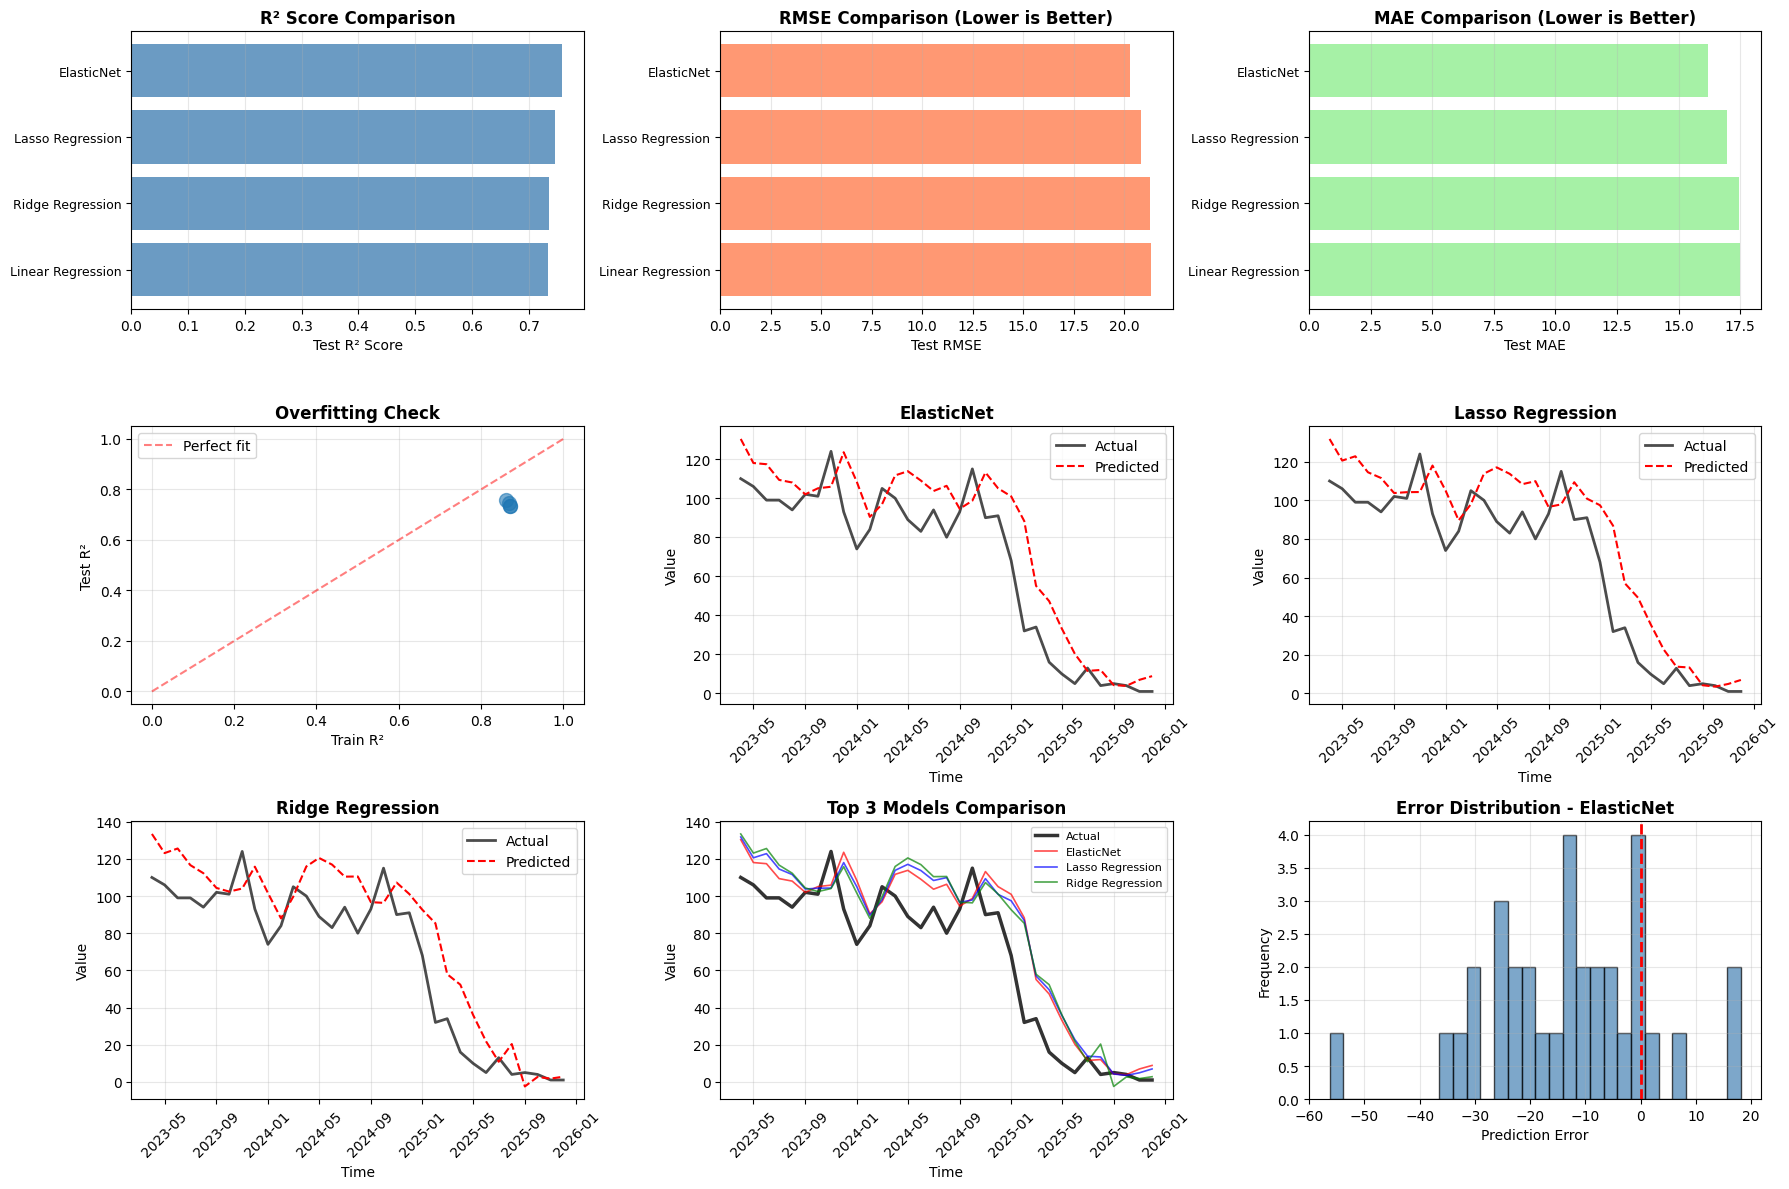

In [12]:
# ============================================================================
# STEP 1: CREATE PROPER TIME SERIES FEATURES
# ============================================================================

# def create_time_series_features(df, target_col='api_count', lags=[1, 2, 3, 6, 12]):
#     """
#     Create time series features from your data
#     """
#     df_features = df.copy()
    
#     # Lag features (previous month values)
#     for lag in lags:
#         df_features[f'lag_{lag}'] = df_features[target_col].shift(lag)
    
#     # Rolling statistics (moving averages, std, etc.)
#     for window in [3, 6, 12]:
#         df_features[f'rolling_mean_{window}'] = df_features[target_col].rolling(window).mean()
#         df_features[f'rolling_std_{window}'] = df_features[target_col].rolling(window).std()
    
#     # Momentum features
#     df_features['diff_1'] = df_features[target_col].diff(1)
#     df_features['pct_change_1'] = df_features[target_col].pct_change(1)
    
#     # Time-based features (from datetime index)
#     df_features['month_feature'] = df_features['month']
#     df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
#     df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
#     # Remove rows with NaN (from lag/rolling calculations)
#     df_features = df_features.dropna()
    
#     return df_features


# ============================================================================
# STEP 2: APPLY FEATURE ENGINEERING TO YOUR DATA
# ============================================================================

# Create features for Corpus Christi data
corpus_christi_with_features = create_time_series_features_predict_well_count(
    cushing_df, 
    target_col='api_count',  # Use ORIGINAL data, not 'lowess'
    lags=[1, 2, 3, 6, 12]
)

print(f"Original rows: {len(cushing_df)}")
print(f"Rows after feature engineering: {len(corpus_christi_with_features)}")
print(f"\nFeatures created:")
for col in corpus_christi_with_features.columns:
    if col not in cushing_df.columns:
        print(f"  - {col}")


# ============================================================================
# STEP 3: RUN THE FORECAST MODEL COMPARISON
# ============================================================================

# Get feature columns (exclude target and metadata columns)
feature_cols = [col for col in corpus_christi_with_features.columns 
                if col not in ['api_count', 'market_center_name', 'year', 'month', 
                               'original', 'lowess', 'Index','predicted_api_count','aggressive_api_count','dormant_api_count']]

print(f"\n{'='*80}")
print(f"Features to use for modeling: {feature_cols}")
print(f"Target variable: api_count")
print(f"{'='*80}\n")

# Run the analysis with CORRECT features and target
results, predictions, best_model, models = quick_forecast_analysis(
    df=corpus_christi_with_features,
    x_col=feature_cols,  # Use lag and rolling features, NOT 'date' or 'Index'
    y_col='api_count',   # Predict original data, NOT 'lowess'
    test_size=0.3
    
)


In [13]:
# ============================================================================
# EXTRACT LINEAR REGRESSION COEFFICIENTS AND EQUATION
# ============================================================================

def get_linear_regression_equation(trained_model, feature_cols):
    """
    Extract coefficients, intercept, and create the equation from trained Linear Regression
    
    Parameters:
    - trained_model: The trained Linear Regression model
    - feature_cols: List of feature column names
    
    Returns:
    - equation_dict: Dictionary with intercept and coefficients
    - equation_string: Human-readable equation string
    """
    from sklearn.linear_model import LinearRegression
    
    # Get coefficients and intercept
    intercept = trained_model.intercept_
    coefficients = trained_model.coef_
    
    # Create dictionary
    equation_dict = {
        'intercept': intercept,
        'coefficients': {}
    }
    
    # Build equation string
    equation_parts = [f"api_count = {intercept:.4f}"]
    
    print("="*80)
    print("LINEAR REGRESSION EQUATION")
    print("="*80)
    print(f"\nIntercept: {intercept:.6f}\n")
    print("Coefficients:")
    print("-" * 80)
    
    for feature, coef in zip(feature_cols, coefficients):
        equation_dict['coefficients'][feature] = coef
        
        # Format coefficient with sign
        sign = "+" if coef >= 0 else ""
        equation_parts.append(f"{sign}{coef:.6f} * {feature}")
        
        print(f"  {feature:20s}: {coef:12.6f}")
    
    equation_string = " \n  ".join(equation_parts)
    
    print("\n" + "="*80)
    print("COMPLETE EQUATION:")
    print("="*80)
    print(equation_string)
    print("="*80)
    
    return equation_dict, equation_string


# ============================================================================
# USE IT WITH YOUR TRAINED MODEL
# ============================================================================

# Get the trained Linear Regression model from your results
linear_reg_model = models['Linear Regression']

# Extract equation
equation_dict, equation_string = get_linear_regression_equation(
    linear_reg_model, 
    feature_cols
)

# ============================================================================
# CREATE A PREDICTION FUNCTION
# ============================================================================

def predict_api_count_manually(features_dict, equation_dict):
    """
    Manually calculate prediction using the equation
    
    Parameters:
    - features_dict: Dictionary with feature values
    - equation_dict: Dictionary with intercept and coefficients
    
    Returns:
    - predicted_value: The predicted api_count
    """
    prediction = equation_dict['intercept']
    
    for feature, value in features_dict.items():
        prediction += equation_dict['coefficients'][feature] * value
    
    return prediction


# Example: Make a prediction for the last row
last_row_features = corpus_christi_with_features[feature_cols].iloc[-1].to_dict()
manual_prediction = predict_api_count_manually(last_row_features, equation_dict)

print(f"\nManual prediction using equation: {manual_prediction:.2f}")
print(f"Actual value: {corpus_christi_with_features['api_count'].iloc[-1]:.2f}")
# ============================================================================
# EXPORT EQUATION TO FILE
# ============================================================================

import json

# Save equation to JSON file
with open('linear_regression_equation.json', 'w') as f:
    json.dump(equation_dict, f, indent=4)

print("\n✅ Equation saved to 'linear_regression_equation.json'")

# Save human-readable equation to text file
with open('linear_regression_equation.txt', 'w') as f:
    f.write(equation_string)

print("✅ Equation saved to 'corpus_christi_linear_regression_equation.txt'")

LINEAR REGRESSION EQUATION

Intercept: 27.159473

Coefficients:
--------------------------------------------------------------------------------
  lag_1               :     0.298590
  lag_2               :     0.248237
  lag_3               :     0.017667
  lag_6               :    -0.107230
  lag_12              :     0.130865
  rolling_mean_3      :     0.188165
  rolling_std_3       :    -0.259109
  rolling_mean_6      :     0.580102
  rolling_std_6       :     0.034850
  rolling_mean_12     :    -0.431389
  rolling_std_12      :    -0.707113
  diff_1              :     0.050353
  pct_change_1        :     8.367841
  month_feature       :     0.633624
  month_sin           :     2.814061
  month_cos           :   -12.774921

COMPLETE EQUATION:
api_count = 27.1595 
  +0.298590 * lag_1 
  +0.248237 * lag_2 
  +0.017667 * lag_3 
  -0.107230 * lag_6 
  +0.130865 * lag_12 
  +0.188165 * rolling_mean_3 
  -0.259109 * rolling_std_3 
  +0.580102 * rolling_mean_6 
  +0.034850 * rolling_std_6

In [15]:
import numpy as np
import pandas as pd

def calculate_regime_multipliers_from_data(historical_data, baseline_window=12, percentile_threshold=75):
    """
    Calculate aggressive multiplier using the paper's methodology [2]

    This is the CORRECT way to get your multipliers instead of guessing

    Parameters:
    - historical_data: Series of monthly api_count
    - baseline_window: Rolling window for baseline (12 months recommended)
    - percentile_threshold: Percentile to define aggressive behavior (75th recommended)

    Returns:
    - Dictionary with baseline_level, aggressive_level, and multipliers
    """

    print("\n" + "="*80)
    print("CALCULATING DATA-DRIVEN MULTIPLIERS FROM HISTORICAL DATA")
    print("="*80)

    # Step 1: Calculate baseline using rolling median (paper's approach) [2]
    baseline = historical_data.rolling(window=baseline_window, center=True).median()
    print(f"\n? Step 1: Calculated baseline using {baseline_window}-month rolling median")

    # Step 2: Calculate deviations from baseline [2]
    deviations = historical_data - baseline
    print(f"? Step 2: Computed deviations from baseline")

    # Step 3: Identify aggressive threshold using percentile [2]
    positive_deviations = deviations[deviations > 0]
    aggressive_threshold = np.percentile(positive_deviations, percentile_threshold)
    print(f"? Step 3: Aggressive threshold = {aggressive_threshold:.2f} wells/month")
    print(f"           (Using {percentile_threshold}th percentile of positive deviations)")

    # Step 4: Flag aggressive months [2]
    is_aggressive = (deviations > aggressive_threshold)
    num_aggressive_months = is_aggressive.sum()
    print(f"? Step 4: Identified {num_aggressive_months} aggressive months")
    print(f"           ({num_aggressive_months/len(historical_data)*100:.1f}% of total months)")

    # Step 5: Calculate baseline level [2]
    baseline_level = baseline.mean()
    print(f"\n? Step 5: Baseline Level = {baseline_level:.2f} wells/month")

    # Step 6: Calculate aggressive level [2]
    aggressive_months_data = historical_data[is_aggressive]
    aggressive_level = aggressive_months_data.mean()
    print(f"? Step 6: Aggressive Level = {aggressive_level:.2f} wells/month")

    # Step 7: Calculate THE MULTIPLIER [2]
    aggressive_multiplier = aggressive_level / baseline_level
    dormant_multiplier = 1.0 / aggressive_multiplier  # Inverse for dormant

    print("\n" + "="*80)
    print("?? RESULTS: DATA-DRIVEN MULTIPLIERS")
    print("="*80)
    print(f"Baseline Level:          {baseline_level:.2f} wells/month")
    print(f"Aggressive Level:        {aggressive_level:.2f} wells/month")
    print(f"")
    print(f"?? AGGRESSIVE MULTIPLIER: {aggressive_multiplier:.3f}x")
    print(f"   (Use this for aggressive scenarios)")
    print(f"")
    print(f"?? DORMANT MULTIPLIER:    {dormant_multiplier:.3f}x")
    print(f"   (Use this for dormant scenarios)")
    print("="*80)

    return {
        'baseline_level': baseline_level,
        'aggressive_level': aggressive_level,
        'aggressive_multiplier': aggressive_multiplier,
        'dormant_multiplier': dormant_multiplier,
        'aggressive_threshold': aggressive_threshold,
        'num_aggressive_months': num_aggressive_months
    }

# Apply to your Houston data
multipliers = calculate_regime_multipliers_from_data(
    corpus_christi_with_features['api_count'].dropna()
)


CALCULATING DATA-DRIVEN MULTIPLIERS FROM HISTORICAL DATA

? Step 1: Calculated baseline using 12-month rolling median
? Step 2: Computed deviations from baseline
? Step 3: Aggressive threshold = 18.50 wells/month
           (Using 75th percentile of positive deviations)
? Step 4: Identified 14 aggressive months
           (11.7% of total months)

? Step 5: Baseline Level = 111.00 wells/month
? Step 6: Aggressive Level = 164.79 wells/month

?? RESULTS: DATA-DRIVEN MULTIPLIERS
Baseline Level:          111.00 wells/month
Aggressive Level:        164.79 wells/month

?? AGGRESSIVE MULTIPLIER: 1.485x
   (Use this for aggressive scenarios)

?? DORMANT MULTIPLIER:    0.674x
   (Use this for dormant scenarios)
